1. DATA편차가 다소 심함
2. augmentation에 대한 기준 설립 (어느 정도 이상의 values를 가진 label을 augmentation해줄지)
3. EDA 기법 적용 (Synonym Replacement, Random Insertion, Random Swap, Random Deletion 방향성 논의)
4. Source별 차이는 있을까?
5. Subject entity 위치 변경
6. 불용어 확인
7. sentence 길이별 문장 선별 + 짧은 문장 drop??
8. 짧은 문장을 학습해도 긴 문장에 적용이 가능할까

## 0. 필요 라이브러리 호출

In [ ]:
!pip install transformers
!git clone https://github.com/KLUE-benchmark/KLUE.git
!pip install matplotlib

In [10]:
from matplotlib import pyplot as plt

from tqdm import tqdm
from transformers import AutoTokenizer
import pandas as pd

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## 1. 데이터 확인

In [126]:
train_data = pd.read_csv ("../dataset/train/train.csv")
train_data.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia


## 2. label 값 기준 시각화 및 augmentation 요소 파악

In [94]:
import pickle

# pkl 파일에서 객체 불러오기
with open('dict_label_to_num.pkl', 'rb') as f:
    label2num = pickle.load(f)

# 불러온 객체 사용하기
print(label2num)

{'no_relation': 0, 'org:top_members/employees': 1, 'org:members': 2, 'org:product': 3, 'per:title': 4, 'org:alternate_names': 5, 'per:employee_of': 6, 'org:place_of_headquarters': 7, 'per:product': 8, 'org:number_of_employees/members': 9, 'per:children': 10, 'per:place_of_residence': 11, 'per:alternate_names': 12, 'per:other_family': 13, 'per:colleagues': 14, 'per:origin': 15, 'per:siblings': 16, 'per:spouse': 17, 'org:founded': 18, 'org:political/religious_affiliation': 19, 'org:member_of': 20, 'per:parents': 21, 'org:dissolved': 22, 'per:schools_attended': 23, 'per:date_of_death': 24, 'per:date_of_birth': 25, 'per:place_of_birth': 26, 'per:place_of_death': 27, 'org:founded_by': 28, 'per:religion': 29}


In [95]:
# pkl 파일에 저장된 num값으로 label값 변경
train_data.loc[train_data['label'].isin(label2num.keys()), 'label'] = train_data['label'].map(label2num)

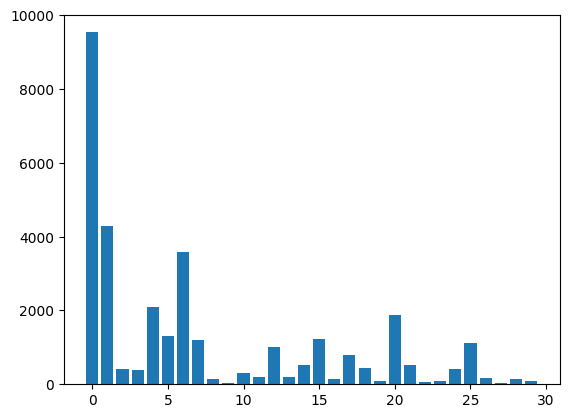

In [108]:
counts = train_data['label'].value_counts()
counts_df = pd.DataFrame({'label': counts.index, 'values': counts.values})

plt.bar(counts_df['label'], counts_df['values'])
plt.show()

In [98]:
# label이 0인 값을 제외하고 평균
# label이 0인 값이 너무 많음
avg_without_zero = (counts_df['values'].sum() - counts_df['values'][0]) // 29
avg_without_zero

790

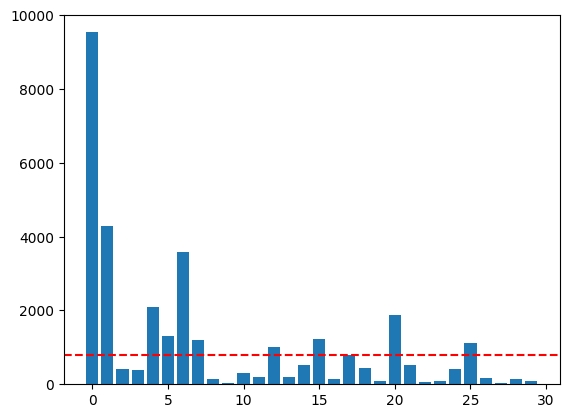

In [99]:
# y = 평균 값 선 추가
plt.bar(counts_df['label'], counts_df['values'])
plt.axhline(y = avg_without_zero, color = 'r', linestyle = '--')
plt.show()

In [100]:
# 평균값에 얼마나 차이가 존재하는지 계산
weighted_counts_df = pd.DataFrame({'label': counts_df['label'], 'weighted_values': counts_df['values'] - avg_without_zero})
weighted_counts_df

,label,weighted_values
0,0,8744
1,1,3494
2,6,2783
3,4,1313
4,20,1076
5,5,530
6,15,444
7,7,405
8,25,340
9,12,211


In [109]:
# 임의의 값 이상을 초과하는 label
mask = abs(weighted_counts_df['weighted_values']) >= (0.75 * avg_without_zero) #임의의 값 0.75
selected_labels = weighted_counts_df.loc[mask, 'label'].tolist()
selected_labels

[0, 1, 6, 4, 20, 11, 13, 26, 28, 8, 16, 19, 29, 23, 22, 9, 27]

In [103]:
# 선택된 label값을 다시 pkl파일을 이용해서 원래의 label 로 전환
with open('dict_num_to_label.pkl', 'rb') as f:
    num2label = pickle.load(f)
num2label

{0: 'no_relation',
 1: 'org:top_members/employees',
 2: 'org:members',
 3: 'org:product',
 4: 'per:title',
 5: 'org:alternate_names',
 6: 'per:employee_of',
 7: 'org:place_of_headquarters',
 8: 'per:product',
 9: 'org:number_of_employees/members',
 10: 'per:children',
 11: 'per:place_of_residence',
 12: 'per:alternate_names',
 13: 'per:other_family',
 14: 'per:colleagues',
 15: 'per:origin',
 16: 'per:siblings',
 17: 'per:spouse',
 18: 'org:founded',
 19: 'org:political/religious_affiliation',
 20: 'org:member_of',
 21: 'per:parents',
 22: 'org:dissolved',
 23: 'per:schools_attended',
 24: 'per:date_of_death',
 25: 'per:date_of_birth',
 26: 'per:place_of_birth',
 27: 'per:place_of_death',
 28: 'org:founded_by',
 29: 'per:religion'}

In [104]:
auglist = []
for i in selected_labels:
    if i in num2label:
        auglist.append(num2label[i])

In [110]:
# 평균으로부터 임의의 값을 초과하는 label
auglist

['no_relation',
 'org:top_members/employees',
 'per:employee_of',
 'per:title',
 'org:member_of',
 'per:place_of_residence',
 'per:other_family',
 'per:place_of_birth',
 'org:founded_by',
 'per:product',
 'per:siblings',
 'org:political/religious_affiliation',
 'per:religion',
 'per:schools_attended',
 'org:dissolved',
 'org:number_of_employees/members',
 'per:place_of_death']

### -> 결론: label 값 별 빈도 수 조절 필요 (추가, 중복 추출, 제거)

## 3. source별 분포 확인

In [127]:
counts_by_source = train_data['source'].value_counts()
print(counts_by_source)

wikipedia          21620
wikitree           10672
policy_briefing      178
Name: source, dtype: int64


### -> 결론: Source별 편향은 없을 것으로 추정되나, baseline 모델 완성 이후 확인해볼 것

## 4. Sentence 길이별 분포 확인

In [218]:
lengths = train_data['sentence'].apply(len)
lengths_df = pd.DataFrame({'sentence_length':lengths})
lengths_df


,sentence_length
0,59
1,54
2,99
3,78
4,56
...,...
32465,213
32466,67
32467,115
32468,65


In [240]:
len(lengths_df[lengths_df['sentence_length'] < 20])

14

In [242]:
len(lengths_df[lengths_df['sentence_length'] < 25])

55

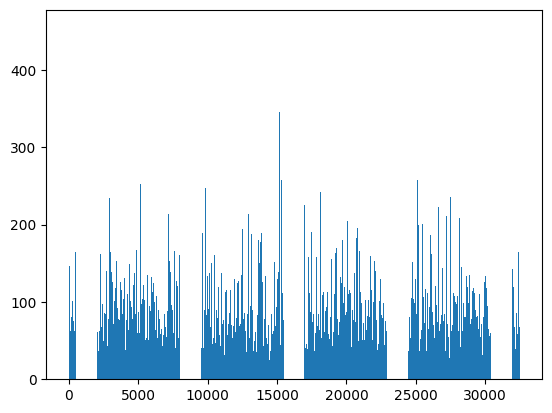

In [244]:
plt.bar(lengths_df.index, lengths_df.sentence_length)
plt.show()
#barplot말고 다른거로 시도 (histogram)
#범위별 추출

In [230]:
bins = [ i for i in range(0,401,50)]
labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400']
lengths_df['length_range'] = pd.cut(lengths_df['sentence_length'], bins=bins, labels=labels)

In [238]:
counts = lengths_df['length_range'].value_counts()
result = pd.DataFrame(counts).reset_index()
result.columns = ['range','values']
result = result.sort_values('range')
result

,range,values
2,0-50,3828
0,51-100,16500
1,101-150,8324
3,151-200,2578
4,201-250,817
5,251-300,261
6,301-350,102
7,351-400,48


<BarContainer object of 8 artists>

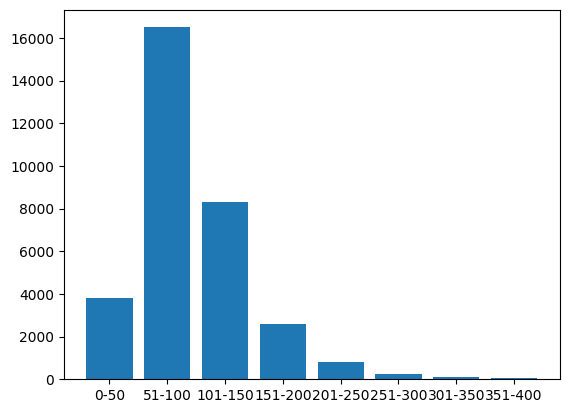

In [239]:
plt.bar(result['range'], result['values'])

In [149]:
test_data = pd.read_csv ("../dataset/test/test_data.csv")

In [150]:
test_lengths = test_data['sentence'].apply(len)
test_lengths_df = pd.DataFrame({'sentence_length':test_lengths})
test_lengths_df

,sentence_length
0,36
1,97
2,345
3,96
4,57
...,...
7760,69
7761,202
7762,62
7763,38


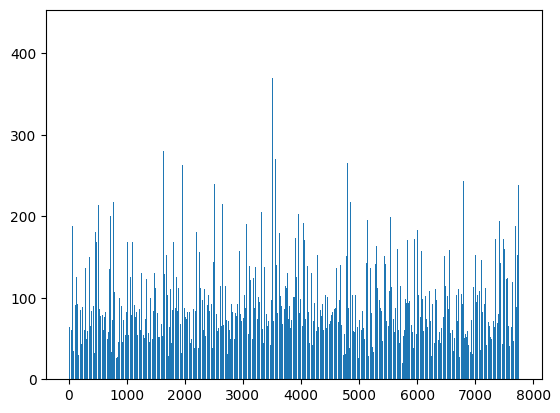

In [151]:
plt.bar(test_lengths_df.index, test_lengths_df.sentence_length)
plt.show()

In [246]:
test_lengths_df['length_range'] = pd.cut(test_lengths_df['sentence_length'], bins=bins, labels=labels)
counts = test_lengths_df['length_range'].value_counts()
test_result = pd.DataFrame(counts).reset_index()
test_result.columns = ['range','values']
test_result = test_result.sort_values('range')
test_result

,range,values
2,0-50,1146
0,51-100,3854
1,101-150,1974
3,151-200,609
4,201-250,128
5,251-300,41
6,301-350,8
7,351-400,4


<BarContainer object of 8 artists>

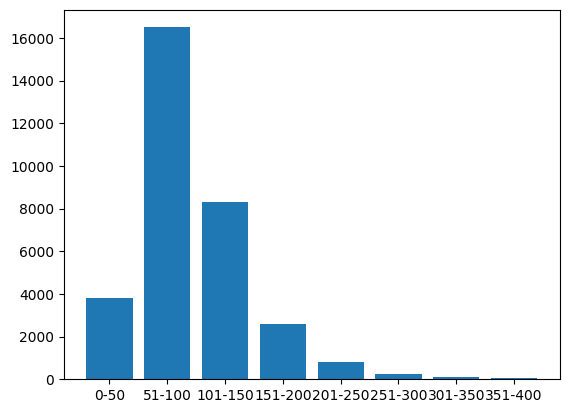

In [247]:
plt.bar(result['range'], result['values'])

### -> 결론: sentence 길이 별 빈도 수 조절 필요 
### 길이가 지나치게 긴 문장, 짧은 문장 제거 (기준 설립 必)

## 5. UNK토큰 확인

In [185]:
def tokenizing(df):
    tokenizer = AutoTokenizer.from_pretrained('klue/roberta-small')
    sentence_len = []
    sentence_unk = []
    for i, item in tqdm(df.iterrows()):
        sentence = tokenizer(item['sentence'])['input_ids']
        sentence_len.append(len(sentence))
        sentence_unk.append(sentence.count(tokenizer.unk_token_id))
    tokenized_df = pd.DataFrame([sentence_len, sentence_unk]).transpose()
    tokenized_df.columns = ['len', 'unk']
    return tokenized_df

In [186]:
tokenized_df = tokenizing(train_data)

32470it [00:11, 2850.07it/s]


In [180]:
tokenized_df

,len,unk
0,33,0
1,36,0
2,50,0
3,44,0
4,29,0
...,...,...
32465,132,0
32466,43,0
32467,59,0
32468,35,0


In [181]:
tokenized_df[tokenized_df['unk']!=0]

,len,unk
7,57,2
21,60,1
52,48,1
83,61,1
91,47,1
...,...,...
32441,44,1
32442,72,1
32446,76,1
32449,76,2


In [187]:
test_tokenized_df = tokenizing(test_data)

7765it [00:02, 2878.38it/s]


In [188]:
test_tokenized_df[test_tokenized_df['unk']!=0]
##언노운토큰 처리?? masking??

,len,unk
16,22,1
32,30,4
51,23,1
59,119,1
69,55,4
...,...,...
7650,57,1
7687,40,1
7739,45,1
7742,41,1
